In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sbn
import pickle
import os
from sklearn.preprocessing import MinMaxScaler

In [3]:
import tensorflow as tf
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Input, Dense, LSTM, Embedding
from tensorflow.python.keras.initializers import RandomUniform
from tensorflow.python.keras.optimizers import RMSprop
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau

/Users/Jeppe/.local/share/virtualenvs/ACFS-LPq-wnhy/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/Jeppe/.local/share/virtualenvs/ACFS-LPq-wnhy/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/Jeppe/.local/share/virtualenvs/ACFS-LPq-wnhy/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 

In [4]:
FIGSIZE = (14,8)

In [5]:
df_breaks = pd.read_pickle('..//data//simulated_breaks_ix.pickle')
df_returns = pd.read_pickle('..//data//simulated_returns.pickle')
df_tangency_portfolio = pd.read_pickle('..//data//simulated_tangency_portfolios.pickle')
df_true_sharp = pd.read_pickle('..//data//sharp_ratios.pickle')

### Identification of model

Since $\sum_{w_i \in W} w_i == 1 $ We can identify the model by predicting all the weights except the last one

In [7]:
#splitting data

# Cleaning and preprocessing

In [6]:
train_frac = 0.9
data_length = len(df_returns)
split_ix = int(train_frac * data_length)

In [7]:
x_train = df_returns[0:split_ix]
x_test = df_returns[split_ix:]

In [8]:
y_train = df_true_sharp[0:split_ix]
y_test = df_true_sharp[split_ix:]

In [9]:
x_scaler, y_scaler = MinMaxScaler(), MinMaxScaler()
x_train_scaled = x_scaler.fit_transform(x_train)
y_train_scaled = y_scaler.fit_transform(y_train)

In [10]:
x_test_scaled = x_scaler.transform(x_test)
y_test_scaled = y_scaler.transform(y_test)

In [11]:
print(x_train_scaled.shape)
print(y_train_scaled.shape)


(1800000, 11)
(1800000, 11)


In [12]:
num_x_signals, num_y_signals = x_train_scaled.shape[1], y_train_scaled.shape[1]
print(num_x_signals, num_y_signals)

11 11


# Data generation

In [13]:
def batch_generator(batch_size, sequence_length):
    """
    Generator function for creating random batches of training-data.
    """

    # Infinite loop.
    while True:
        # Allocate a new array for the batch of input-signals.
        x_shape = (batch_size, sequence_length, num_x_signals)
        x_batch = np.zeros(shape=x_shape, dtype=np.float16)

        # Allocate a new array for the batch of output-signals.
        y_shape = (batch_size, sequence_length, num_y_signals)
        y_batch = np.zeros(shape=y_shape, dtype=np.float16)

        # Fill the batch with random sequences of data.
        for i in range(batch_size):
            # Get a random start-index.
            # This points somewhere into the training-data.
            idx = np.random.randint(split_ix - sequence_length)
            
            # Copy the sequences of data starting at this index.
            x_batch[i] = x_train_scaled[idx:idx+sequence_length]
            y_batch[i] = y_train_scaled[idx:idx+sequence_length]
        
        yield (x_batch, y_batch)

In [14]:
batch_size = 256 # number of sequences
sequence_length = 250

In [15]:
generator = batch_generator(batch_size=batch_size, sequence_length=sequence_length)

In [16]:
x_batch, y_batch = next(generator)

In [17]:
x_batch.shape, y_batch.shape

((256, 250, 11), (256, 250, 11))

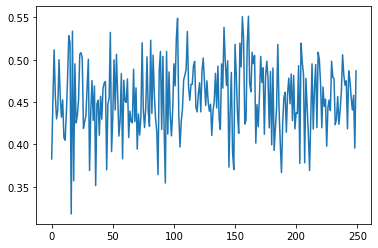

In [18]:
batch = 0   # First sequence in the batch.
signal = 0  # First signal from the 20 input-signals.
seq = x_batch[batch, :, signal]
plt.plot(seq)

In [19]:
validation_data = (np.expand_dims(x_test_scaled, axis=0),
                   np.expand_dims(y_test_scaled, axis=0))

# LSTM model

In [20]:
model = Sequential()
model.add(LSTM(units=256,
              return_sequences=True,
              input_shape=(None, num_x_signals,)))

init = RandomUniform(minval=-0.05, maxval=0.05)

model.add(Dense(num_y_signals,
                activation='linear',
                kernel_initializer=init))

#model.add(Dense(num_y_signals, activation='sigmoid'))


W0811 13:37:42.894019 4537607616 deprecation.py:506] From /Users/Jeppe/.local/share/virtualenvs/ACFS-LPq-wnhy/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0811 13:37:43.119721 4537607616 deprecation.py:506] From /Users/Jeppe/.local/share/virtualenvs/ACFS-LPq-wnhy/lib/python3.7/site-packages/tensorflow/python/keras/initializers.py:119: calling RandomUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [21]:
warmup_steps = 50
def loss_mse_warmup(y_true, y_pred):
    """
    Calculate the Mean Squared Error between y_true and y_pred,
    but ignore the beginning "warmup" part of the sequences.
    
    y_true is the desired output.
    y_pred is the model's output.
    """

    # The shape of both input tensors are:
    # [batch_size, sequence_length, num_y_signals].

    # Ignore the "warmup" parts of the sequences
    # by taking slices of the tensors.
    y_true_slice = y_true[:, warmup_steps:, :]
    y_pred_slice = y_pred[:, warmup_steps:, :]

    # These sliced tensors both have this shape:
    # [batch_size, sequence_length - warmup_steps, num_y_signals]

    # Calculate the MSE loss for each value in these tensors.
    # This outputs a 3-rank tensor of the same shape.
    loss = tf.losses.mean_squared_error(labels=y_true_slice,
                                        predictions=y_pred_slice)

    # Keras may reduce this across the first axis (the batch)
    # but the semantics are unclear, so to be sure we use
    # the loss across the entire tensor, we reduce it to a
    # single scalar with the mean function.
    loss_mean = tf.reduce_mean(loss)

    return loss_mean

In [22]:
optimizer = RMSprop(lr=1e-3)

In [23]:
model.compile(loss=loss_mse_warmup, optimizer=optimizer)

W0811 13:37:52.620244 4537607616 deprecation.py:323] From /Users/Jeppe/.local/share/virtualenvs/ACFS-LPq-wnhy/lib/python3.7/site-packages/tensorflow/python/ops/losses/losses_impl.py:121: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, None, 256)         274432    
_________________________________________________________________
dense (Dense)                (None, None, 11)          2827      
Total params: 277,259
Trainable params: 277,259
Non-trainable params: 0
_________________________________________________________________


In [25]:
path_checkpoint = 'acfs.keras'
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                      monitor='val_loss',
                                      verbose=1,
                                      save_weights_only=True,
                                      save_best_only=True)

In [26]:
callback_early_stopping = EarlyStopping(monitor='val_loss',
                                        patience=5, verbose=1)

In [27]:
callback_tensorboard = TensorBoard(log_dir='./acfs_logs/',
                                   histogram_freq=0,
                                   write_graph=False)

In [28]:
callback_reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                       factor=0.1,
                                       min_lr=1e-4,
                                       patience=0,
                                       verbose=1)

In [29]:
callbacks = [callback_early_stopping,
             callback_checkpoint,
             callback_tensorboard,
             callback_reduce_lr]

In [30]:
%%time
model.fit_generator(generator=generator,
                    epochs=4,
                    steps_per_epoch=100,
                    validation_data=validation_data,
                    callbacks=callbacks)

Epoch 1/5
 99/100 [============================>.] - ETA: 3s - loss: 0.0013
Epoch 00001: val_loss improved from inf to 0.00100, saving model to acfs.keras
100/100 [==============================] - 359s 4s/step - loss: 0.0013 - val_loss: 9.9808e-04
Epoch 2/5
 99/100 [============================>.] - ETA: 3s - loss: 0.0012
Epoch 00002: val_loss improved from 0.00100 to 0.00096, saving model to acfs.keras

Epoch 00002: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
100/100 [==============================] - 429s 4s/step - loss: 0.0012 - val_loss: 9.6419e-04
Epoch 3/5
 99/100 [============================>.] - ETA: 4s - loss: 0.0011
Epoch 00003: val_loss improved from 0.00096 to 0.00094, saving model to acfs.keras

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0001.
100/100 [==============================] - 553s 6s/step - loss: 0.0011 - val_loss: 9.3557e-04
Epoch 4/5
 68/100 [===================>..........] - ETA: 2:36 - loss: 0.0011

KeyboardInterrupt: 

In [31]:
try:
    model.load_weights(path_checkpoint)
except Exception as error:
    print("Error trying to load checkpoint.")
    print(error)

In [32]:
result = model.evaluate(x=np.expand_dims(x_test_scaled, axis=0),
                        y=np.expand_dims(y_test_scaled, axis=0))

1/1 [==============================] - 97s 97s/sample - loss: 9.3557e-04


In [33]:
print("loss (test-set):", result)

loss (test-set): 0.0009355685906484723


In [34]:
target_names = list(df_tangency_portfolio.columns[0:-1])
def plot_comparison(start_idx, length=100, train=True):
    """
    Plot the predicted and true output-signals.
    
    :param start_idx: Start-index for the time-series.
    :param length: Sequence-length to process and plot.
    :param train: Boolean whether to use training- or test-set.
    """
    
    if train:
        # Use training-data.
        x = x_train_scaled
        y_true = np.array(y_train)
    else:
        # Use test-data.
        x = x_test_scaled
        y_true = np.array(y_test)
    
    # End-index for the sequences.
    end_idx = start_idx + length
    
    # Select the sequences from the given start-index and
    # of the given length.
    x = x[start_idx:end_idx]
    y_true = y_true[start_idx:end_idx]
    
    # Input-signals for the model.
    x = np.expand_dims(x, axis=0)

    # Use the model to predict the output-signals.
    y_pred = model.predict(x)
    
    # The output of the model is between 0 and 1.
    # Do an inverse map to get it back to the scale
    # of the original data-set.
    y_pred_rescaled = y_scaler.inverse_transform(y_pred[0])
    
    # For each output-signal.
    for signal in range(len(target_names)):
        # Get the output-signal predicted by the model.
        signal_pred = y_pred_rescaled[:, signal]
        
        # Get the true output-signal from the data-set.
        signal_true = y_true[:, signal]

        # Make the plotting-canvas bigger.
        plt.figure(figsize=(15,5))
        
        # Plot and compare the two signals.
        plt.plot(signal_true, label='true')
        plt.plot(signal_pred, label='pred')
        
        # Plot grey box for warmup-period.
        p = plt.axvspan(0, warmup_steps, facecolor='black', alpha=0.15)
        
        # Plot labels etc.
        plt.ylabel(target_names[signal])
        plt.legend()
        plt.show()

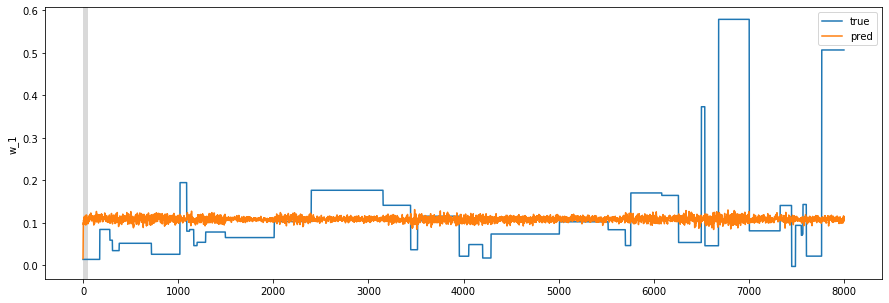

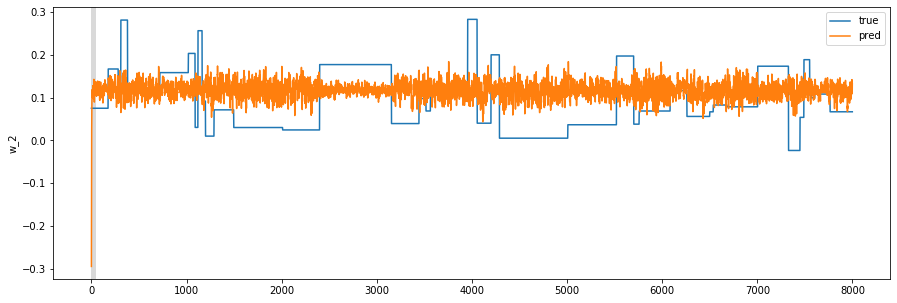

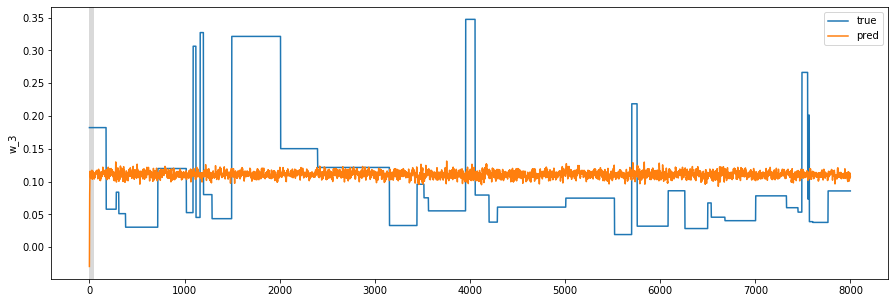

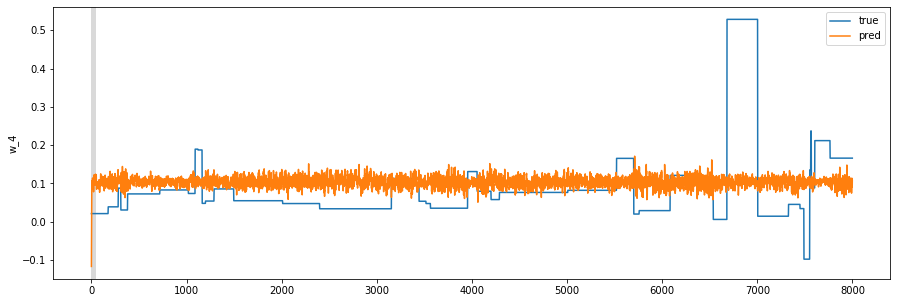

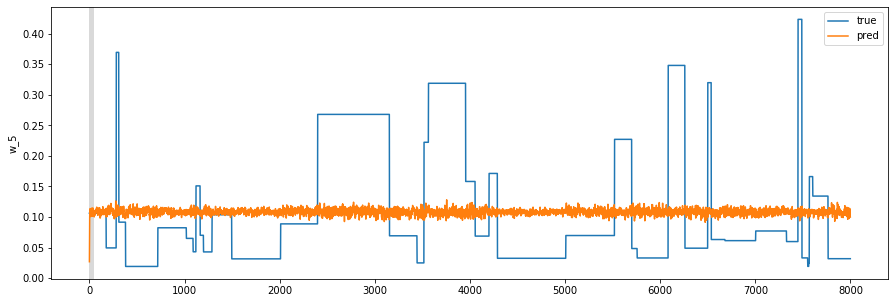

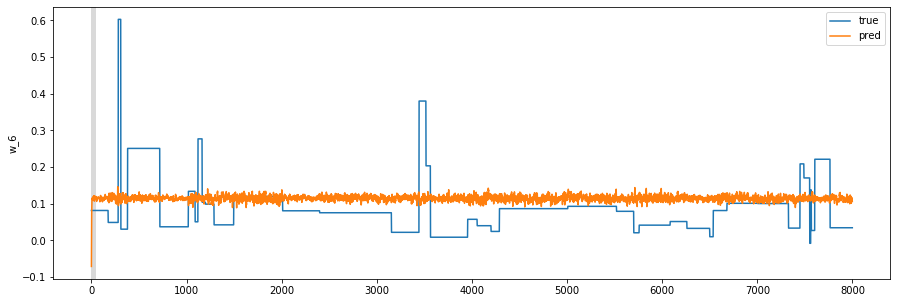

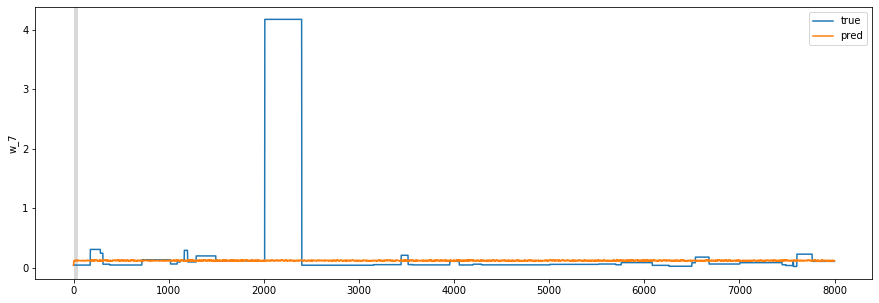

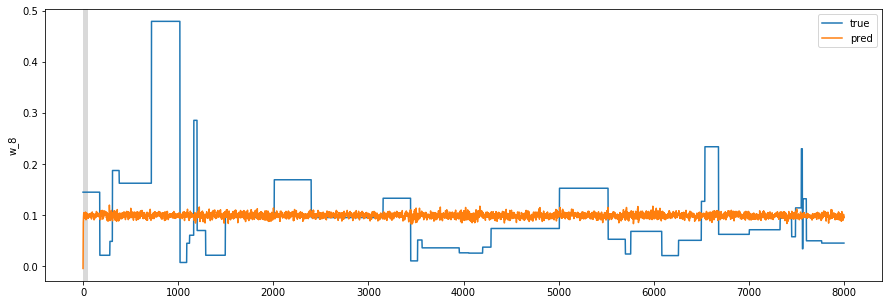

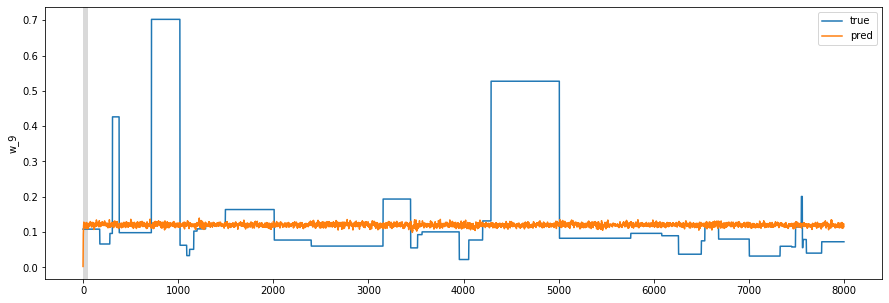

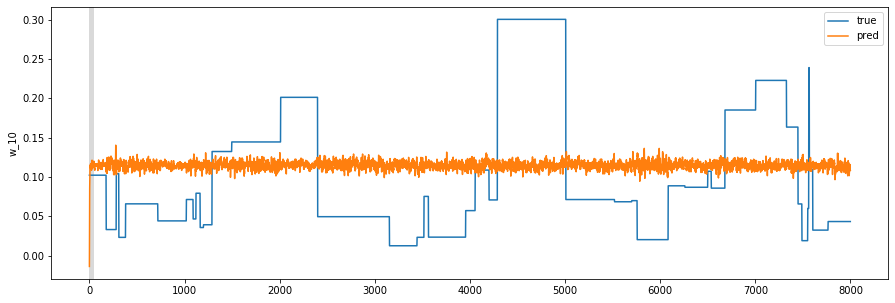

In [36]:
plot_comparison(start_idx=3000, length=8000, train=True)

In [38]:
start_idx, length = 0, 5000
x = x_train_scaled
y_true = np.array(y_train)

end_idx = start_idx + length

# Select the sequences from the given start-index and
# of the given length.
x = x[start_idx:end_idx]
y_true = y_true[start_idx:end_idx]

# Input-signals for the model.
x = np.expand_dims(x, axis=0)

# Use the model to predict the output-signals.
y_pred = model.predict(x)

y_pred_rescaled = y_scaler.inverse_transform(y_pred[0])


In [41]:
mse_df = pd.DataFrame(y_pred_rescaled, columns = [f's_{i}' for i in range(1,12)])

In [43]:
((mse_df - df_true_sharp.iloc[0:5000])**2).mean(axis=1).mean()

0.015606234041735877

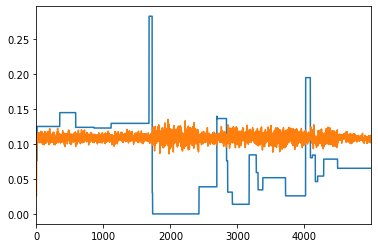

In [47]:
df_true_sharp.iloc[0:5000]['s_1'].plot()
mse_df['s_1'].plot()